<a href="https://colab.research.google.com/github/ManikandanM13/BOA-DENSENET/blob/main/BOA_DEN_predict_ok_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
import math
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, models
import sklearn.metrics
from sklearn.svm import SVC

In [3]:
#Load the dataset
file_path = '/content/drive/MyDrive/ColonTumor (1).csv'
df = pd.read_csv(file_path)
#Display the first few rows to understand the structure
print(df.head())

    Patients  Gene 1  Gene 2  Gene 3  Gene 4  Gene 5  Gene 6  Gene 7  Gene 8  \
0  Patient 1  8590.0  5470.0  4260.0  4060.0  2000.0  5280.0  2170.0  2770.0   
1  Patient 2  9160.0  6720.0  4880.0  3720.0  2020.0  5570.0  3850.0  2790.0   
2  Patient 3  3830.0  6970.0  5370.0  4710.0  1170.0  1570.0  1330.0  1470.0   
3  Patient 4  6250.0  7820.0  5960.0  3980.0  2000.0  2130.0  1530.0  1710.0   
4  Patient 5  3230.0  3690.0  3400.0  3460.0  2180.0  2920.0  2070.0  2950.0   

   Gene 9  ...  Gene 1992  Gene 1993  Gene 1994  Gene 1995  Gene 1996  \
0  7530.0  ...       67.6     260.00      139.0       88.2       39.7   
1  7020.0  ...       92.2      96.30      151.0       82.2       85.0   
2  3300.0  ...       82.7      31.10      194.0       77.0      225.0   
3  3870.0  ...       41.7       5.93      183.0       74.5       67.7   
4  3300.0  ...       76.6     161.00       61.7       54.6      223.0   

   Gene 1997  Gene 1998  Gene 1999  Gene 2000    result  
0       67.8       75.

In [4]:
#Handle missing values, drop row if missing..
df = df.dropna()
df.shape

(62, 2002)

In [5]:
# Handle categorical variables
label_encoder = LabelEncoder()
df['result'] = label_encoder.fit_transform(df['result'])

In [6]:
# Split the dataset into features and labels
X = df.drop('result', axis=1)
y = df['result']  # Labelsprint(df.info())# Assuming 'Patients' is the column with patient identifiers
X = X.drop('Patients', axis=1)#  Min-Max Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**BOA**

In [8]:
def butterfly_optimization(X_train, y_train, n_iterations):
    n_features = X_train.shape[1]
    n_population = 1936  # Number of butterflies
    n_global_search = int(0.4 * n_iterations)  # Percentage of iterations for global search
    n_local_search = n_iterations - n_global_search  # Percentage of iterations for local search
    switch_probability = 0.5  # Switching probability between global and local search

    # Initialize selected features randomly
    selected_features = np.random.choice(n_features, n_population, replace=True)
    best_solution = None
    best_fitness = 0

    for iteration in range(n_iterations):
        # Determine search phase
        if np.random.rand() < switch_probability:
            phase = "global"  # Global search
        else:
            phase = "local"  # Local search

        if phase == "global":
            # Perform global search (exploration)
            for i in range(n_population):
                # Randomly select a feature to update
                feature_to_update = np.random.randint(n_features)

                # Update the feature randomly
                selected_features[i] = feature_to_update
        else:
            # Perform local search (exploitation)
            for i in range(n_population):
                # Randomly select two butterflies other than the current one
                other_butterflies = np.random.choice(n_population, size=2, replace=False)
                butterfly_j, butterfly_k = other_butterflies

                # Update the feature based on BOA equations
                feature_to_update = int(0.5 * (selected_features[butterfly_j] - selected_features[butterfly_k]))

        # Evaluate the fitness of the selected features
        fitness = evaluate_fitness(X_train[:, selected_features], y_train)

        # Update the best solution if needed
        if fitness > best_fitness:
            best_solution = selected_features.copy()
            best_fitness = fitness

    # Return the best solution
    return best_solution


In [9]:
# Define a function to evaluate the fitness of selected features using SVM classifier
def evaluate_fitness(X_selected, y):

    # Initialize and train the SVM classifier
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)

    # Evaluate the trained model on the testing set
    accuracy = svm.score(X_test, y_test)

    return accuracy

In [10]:
# Apply BOA for feature selection
selected_features_indices = butterfly_optimization(X, y, n_iterations=100,)

# Select the features based on the indices
selected_features = X[:, selected_features_indices]

In [11]:
# Split the dataset into training and testing sets using the selected features
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)


In [12]:
print(selected_features.shape)

(62, 1936)


In [13]:
print(X_train.shape)

(49, 1936)


In [14]:
# Assuming nrows, ncols is the shape of the selected features
nrows, ncols = X_train.shape
size = int(np.sqrt(ncols))  # Assuming the images are square

# Normalize the data to the range [0, 255]
min_val = np.min(X_train)
max_val = np.max(X_train)
X_train_normalized = ((X_train - min_val) / (max_val - min_val) * 255).astype(np.uint8)

# Convert the normalized features to a 2D image, where each row is an image
image_data = X_train_normalized.reshape((nrows, size, size))

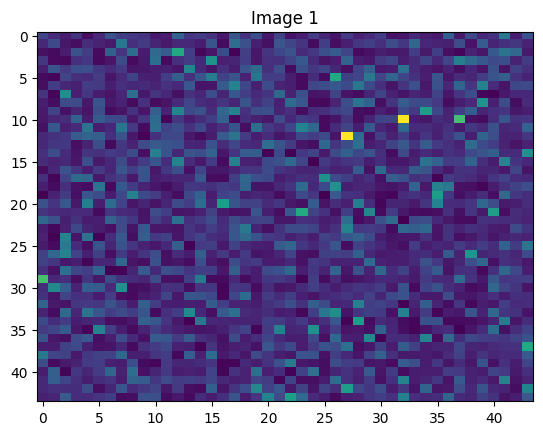

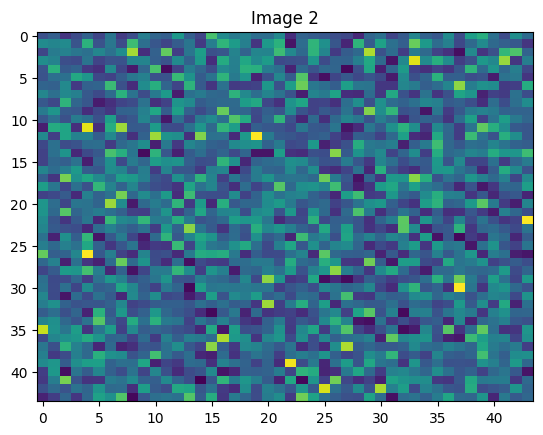

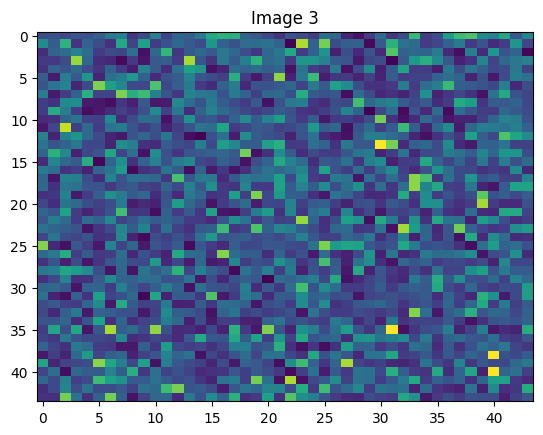

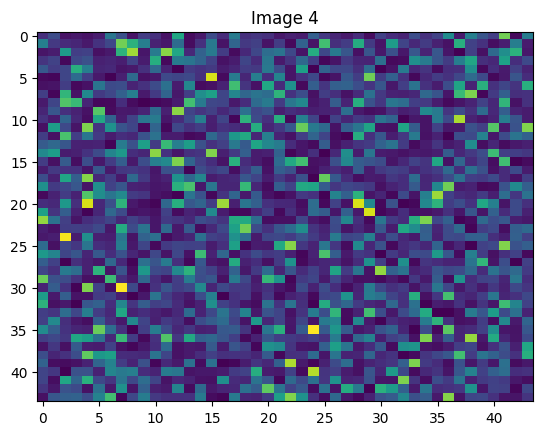

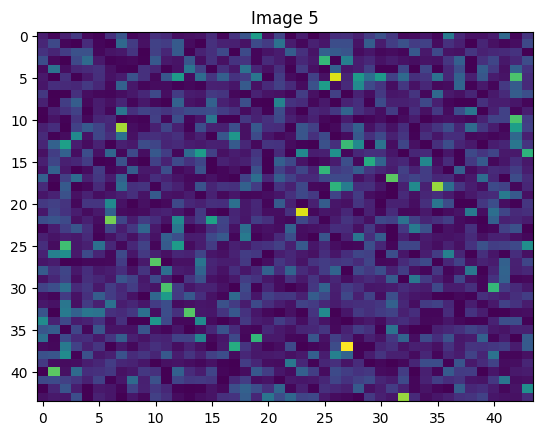

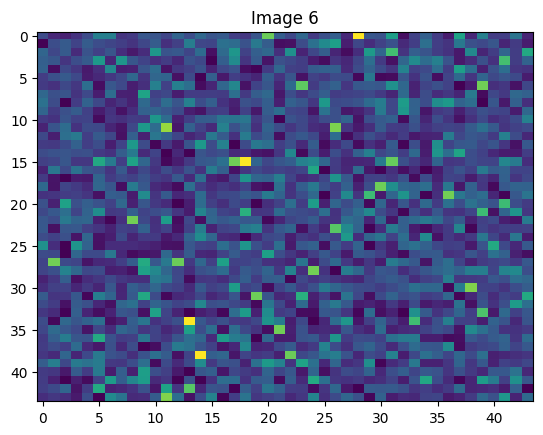

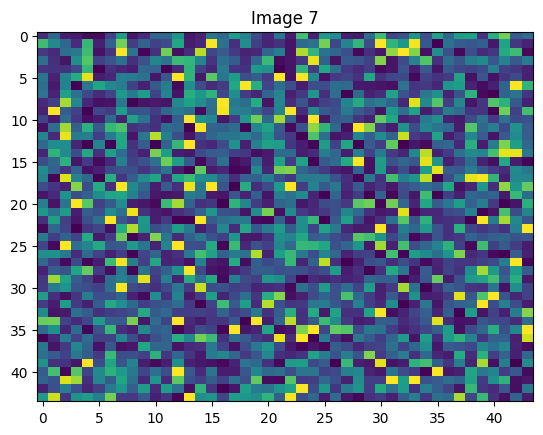

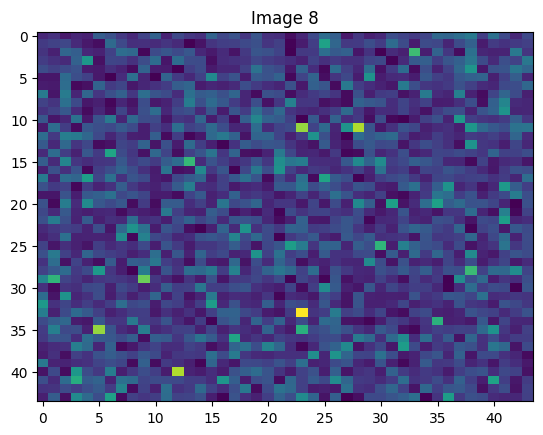

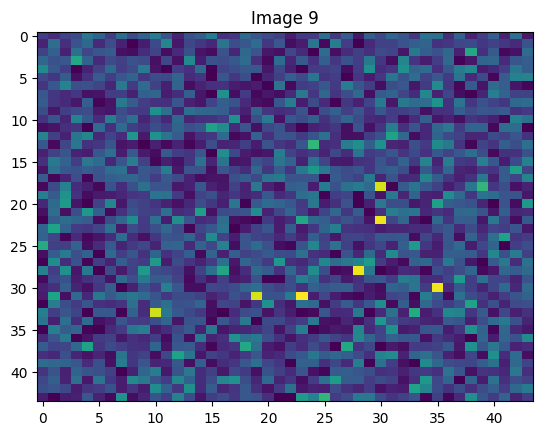

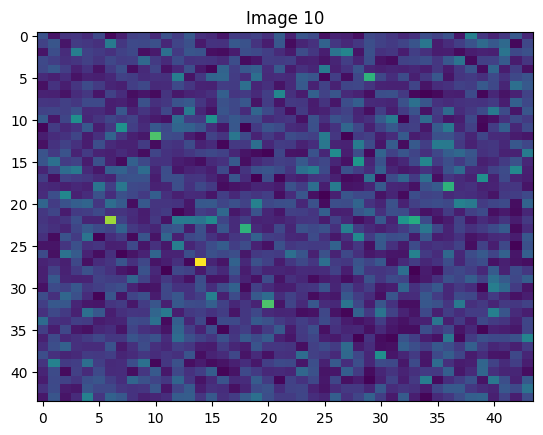

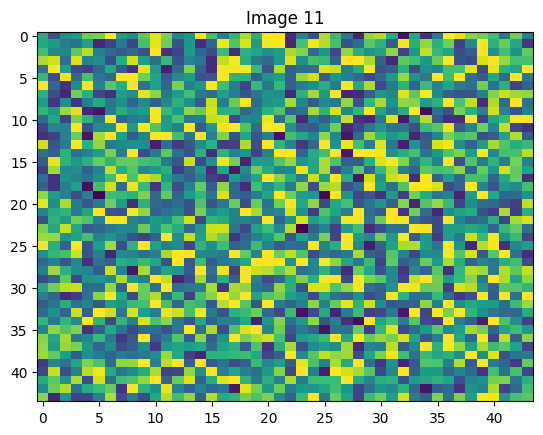

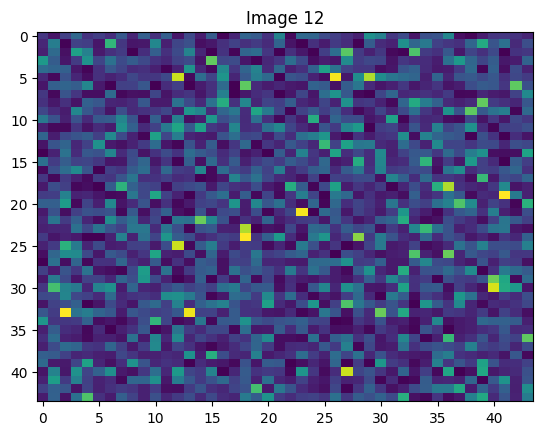

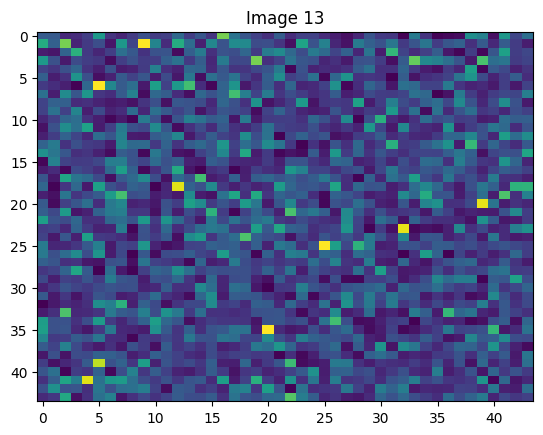

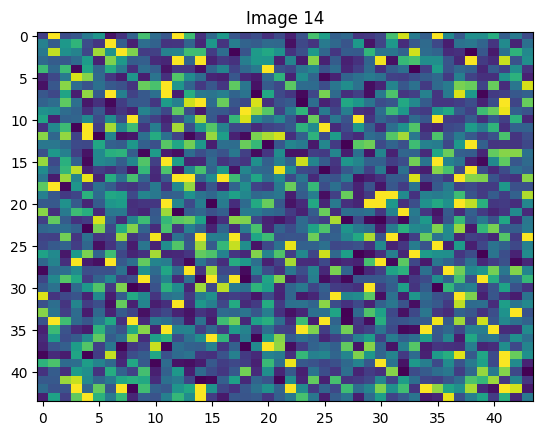

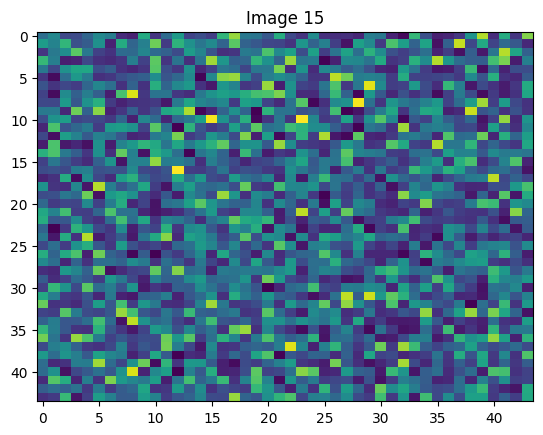

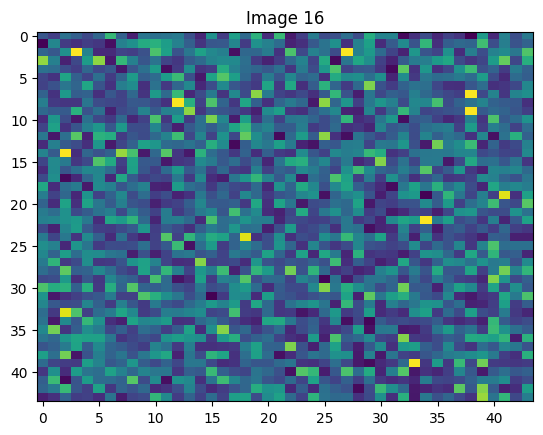

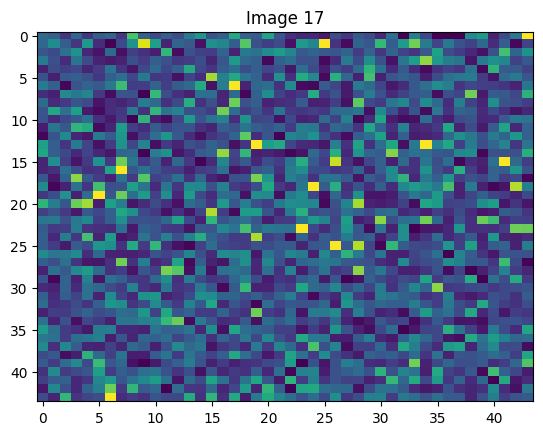

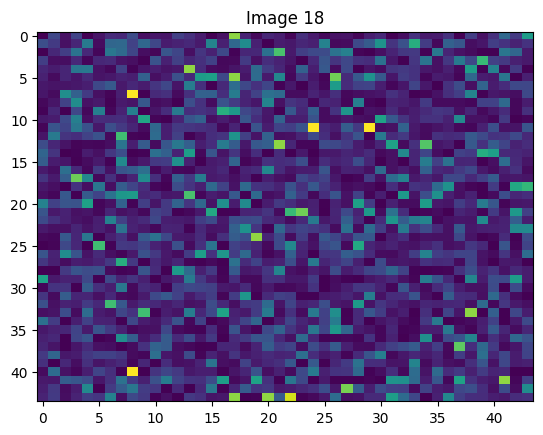

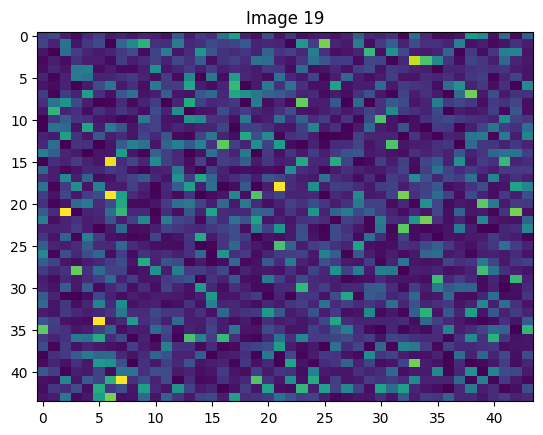

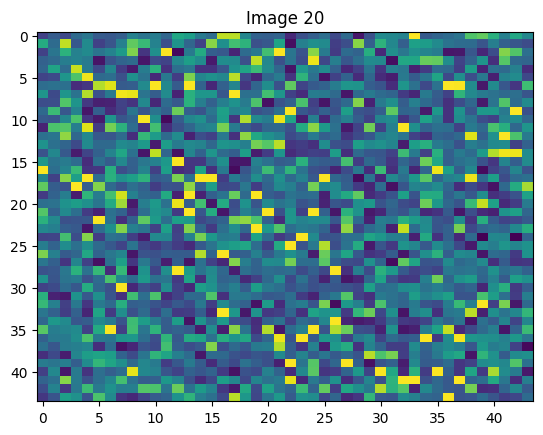

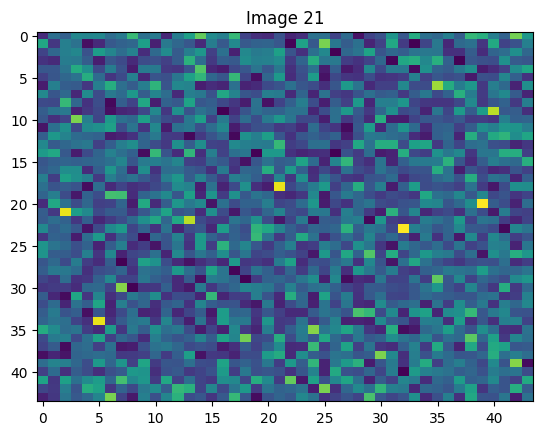

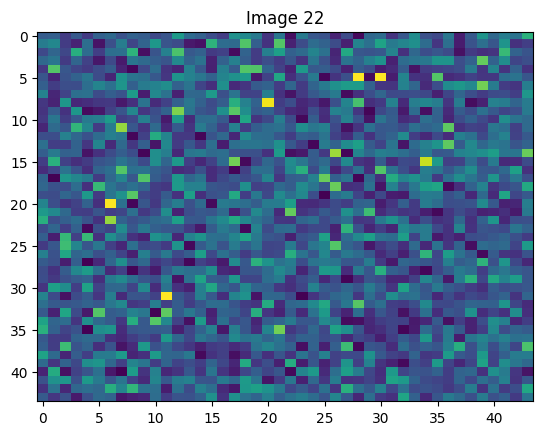

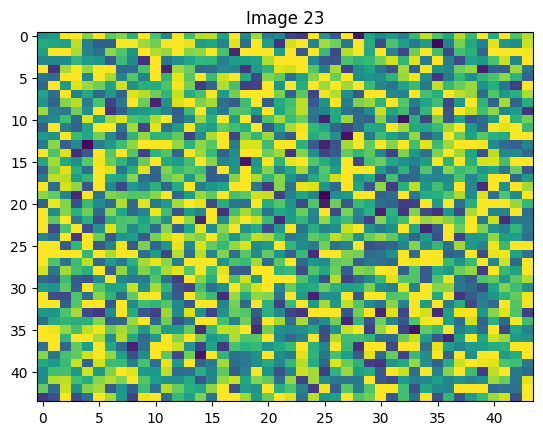

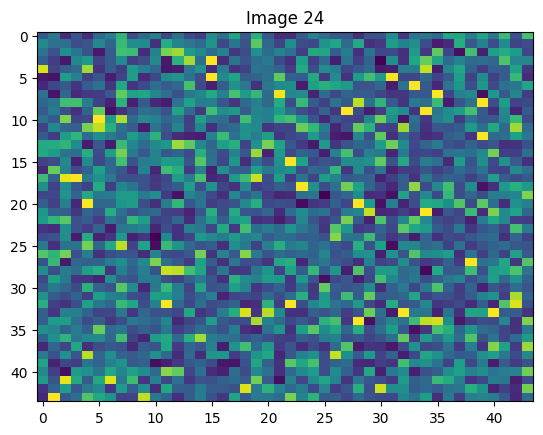

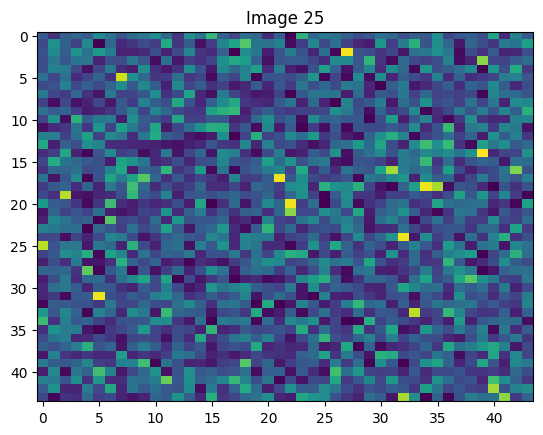

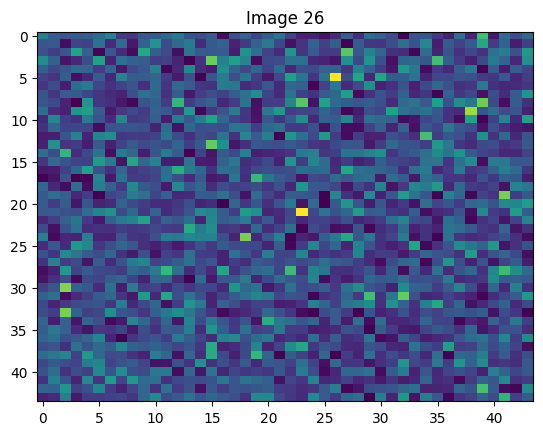

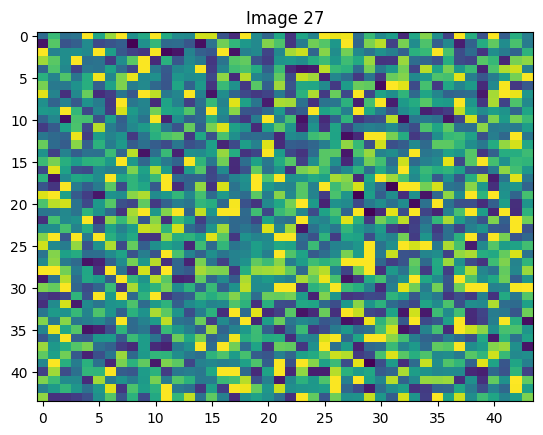

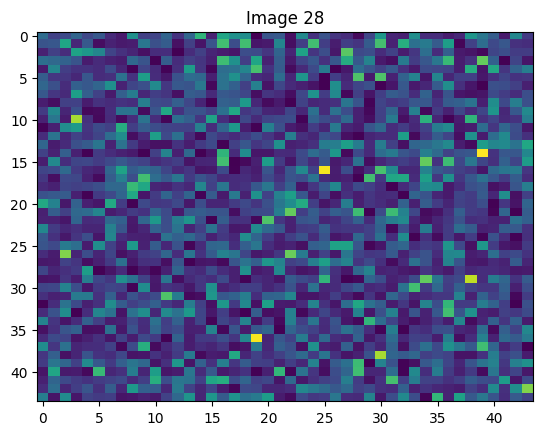

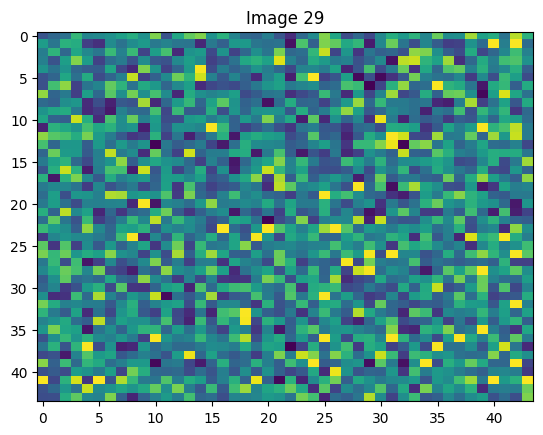

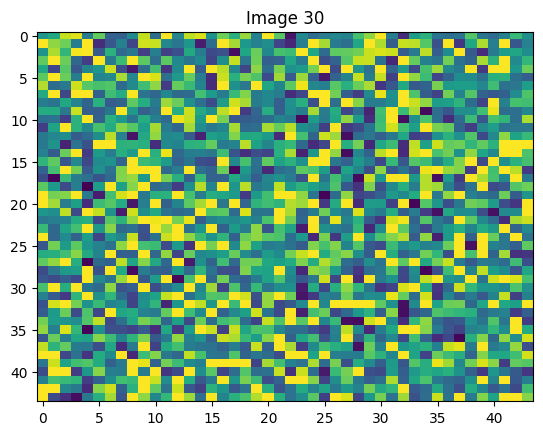

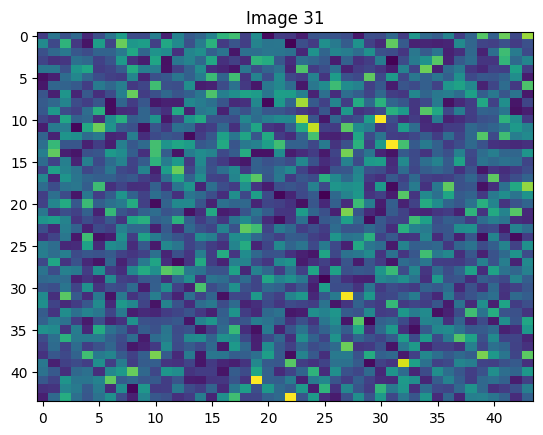

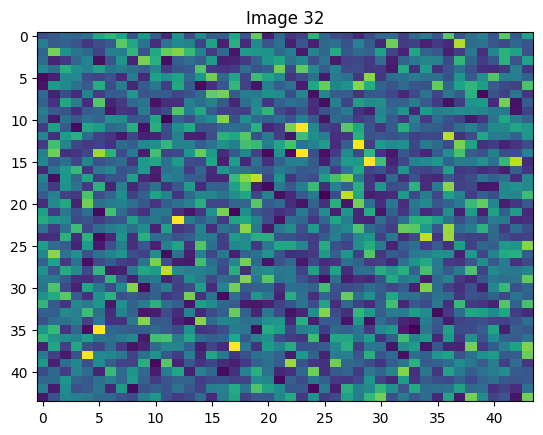

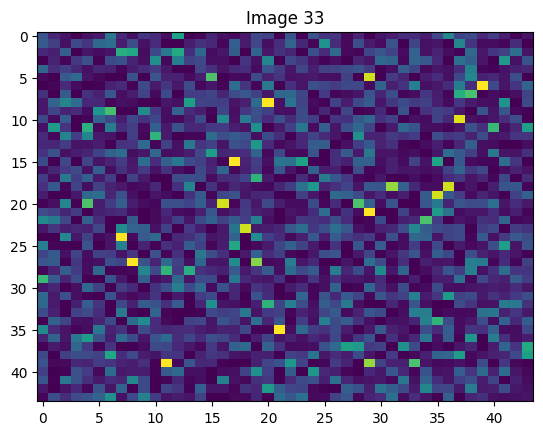

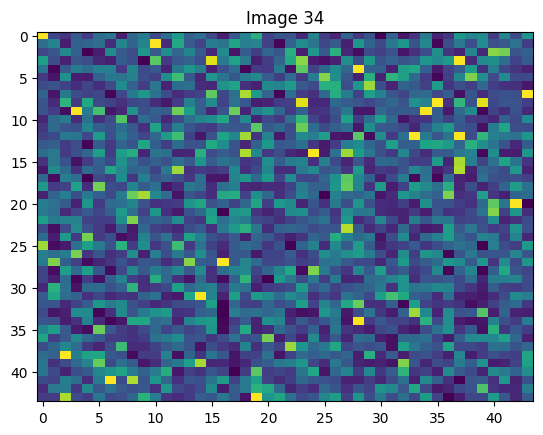

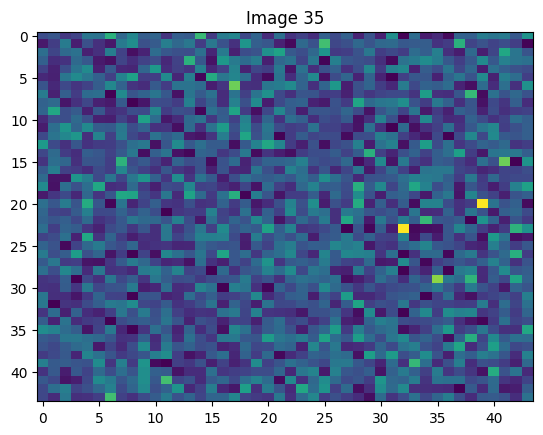

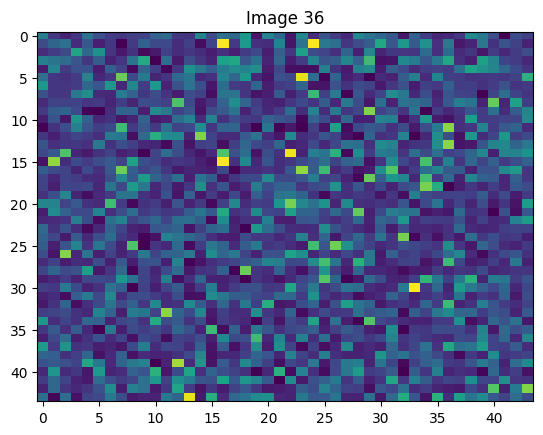

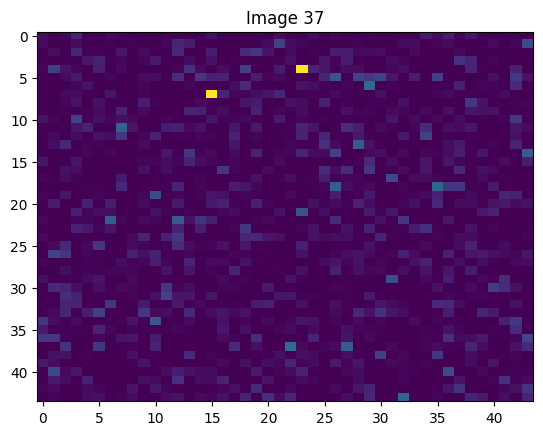

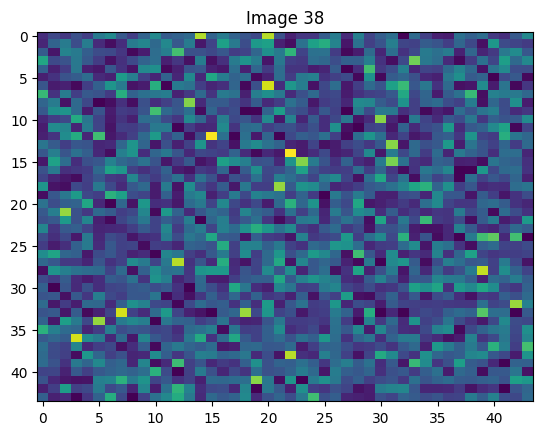

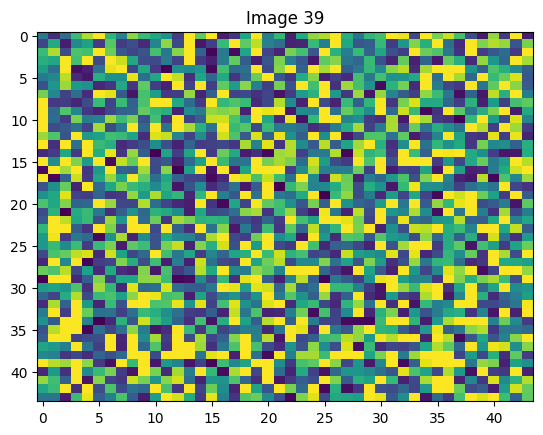

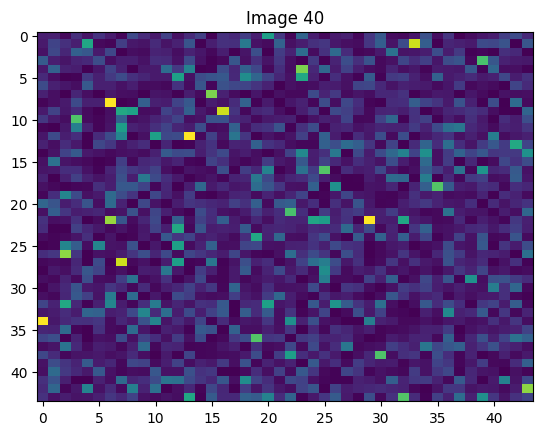

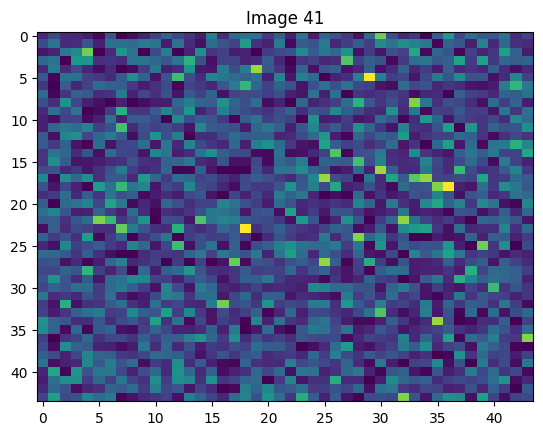

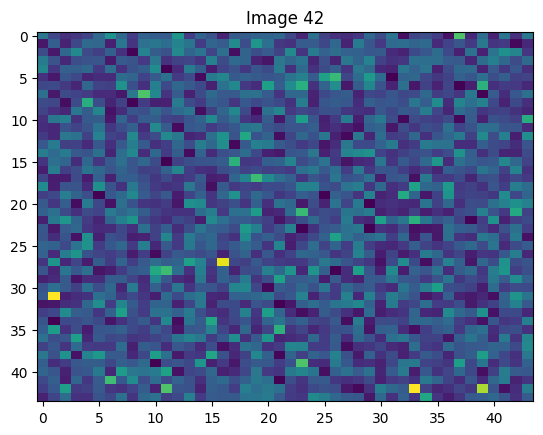

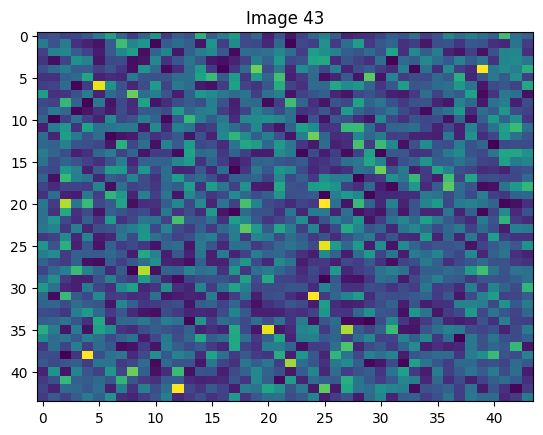

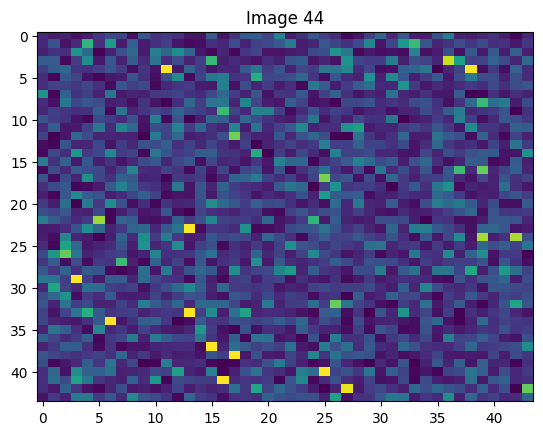

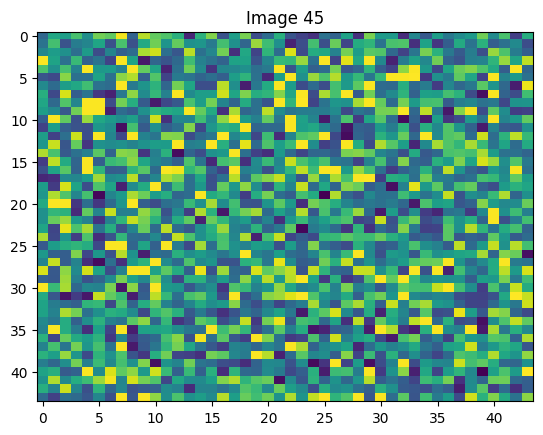

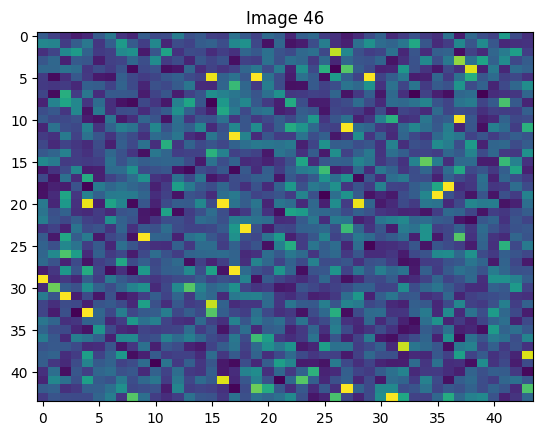

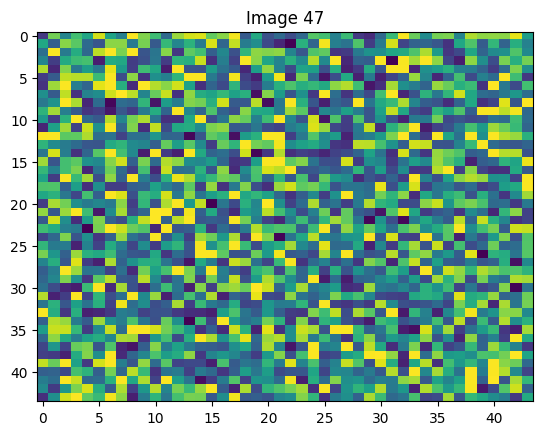

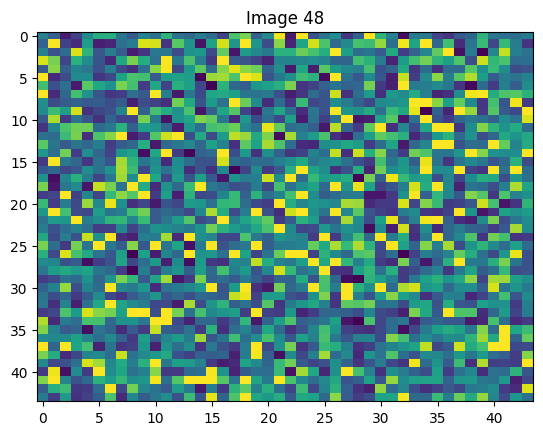

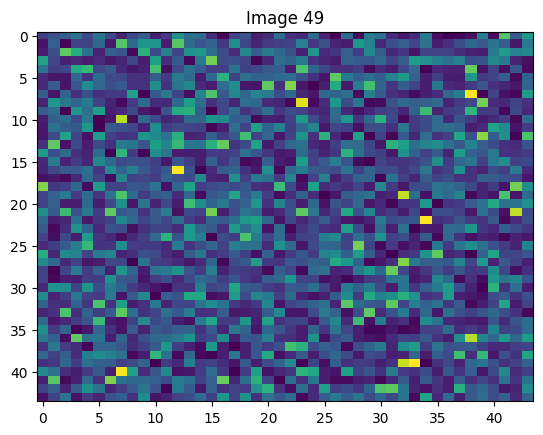

In [15]:
# Display all images
for i in range(nrows):
    plt.imshow(image_data[i], cmap='viridis', aspect='auto')
    plt.title(f"Image {i + 1}")
    plt.show()

**DENSENET**

In [16]:
# Build a DenseNet model without reshaping
from tensorflow.keras import regularizers

def build_densenet_model(input_shape, l1_strength=0.01):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))  # Flatten the 2D images
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(l1_strength)))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(l1_strength)))
    model.add(layers.Dense(1, activation='sigmoid'))  # binary classification
    return model


In [17]:
# X_train_df.shape[1:] is the input shape
densenet_model = build_densenet_model(image_data.shape[1:])

# Compile the model
densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = densenet_model.fit(image_data, y_train, epochs=17, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = densenet_model.predict(image_data)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

# Calculate precision, recall,accuracy and F1 score
precision = sklearn.metrics.precision_score(y_train, y_pred_binary)
recall = sklearn.metrics.recall_score(y_train, y_pred_binary)
f1 = sklearn.metrics.f1_score(y_train, y_pred_binary)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_binary)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
# Save the trained model (optional)
densenet_model.save('densenet_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.6119 - loss: 85.5231 - val_accuracy: 0.4000 - val_loss: 67.9622
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3435 - loss: 71.1373 - val_accuracy: 0.5000 - val_loss: 50.4214
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5502 - loss: 48.2577 - val_accuracy: 0.6000 - val_loss: 55.5483
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6699 - loss: 50.1796 - val_accuracy: 0.6000 - val_loss: 77.2000
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6528 - loss: 62.7446 - val_accuracy: 0.6000 - val_loss: 74.0853
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6907 - loss: 57.1831 - val_accuracy: 0.5000 - val_loss: 45.9631
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7903 - loss: 40.9802 - val_accuracy: 0.5000 - val_loss: 63.7530
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4602 - loss: 57.7518 - val_accuracy: 0.6000 - v

(13, 44, 44)


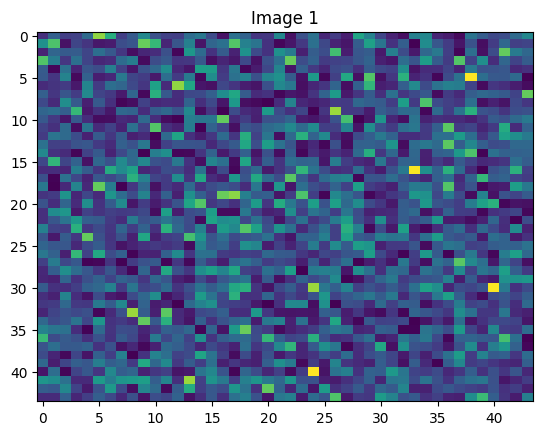

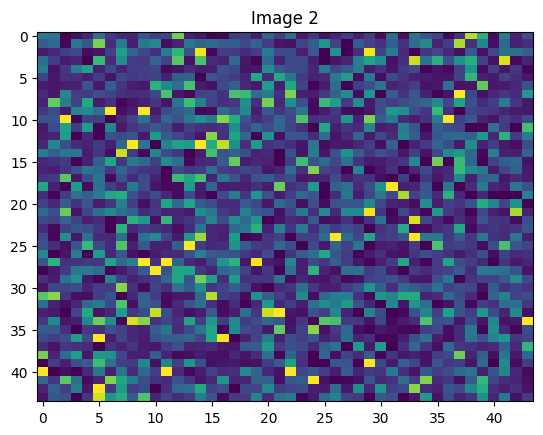

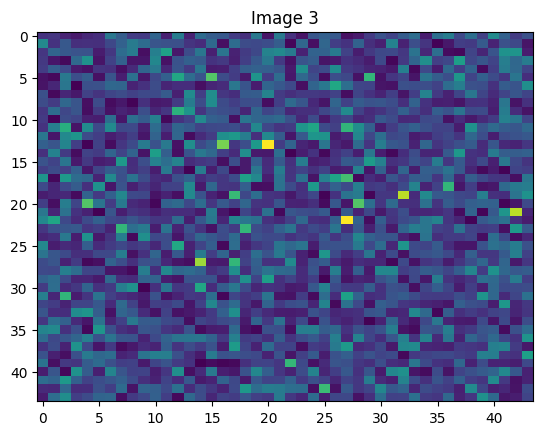

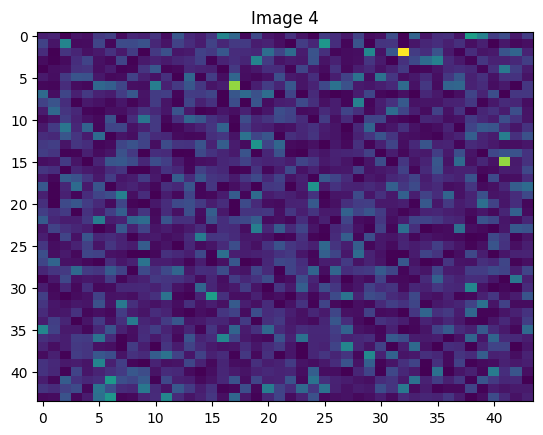

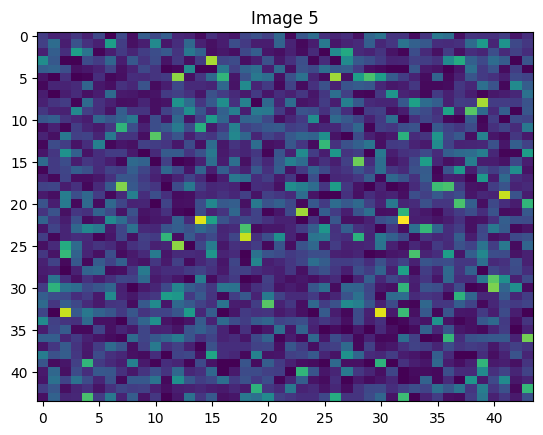

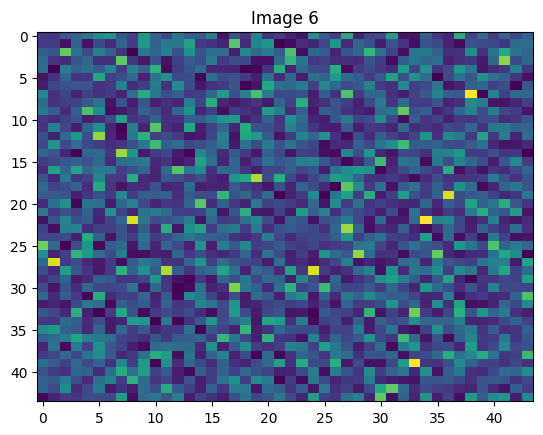

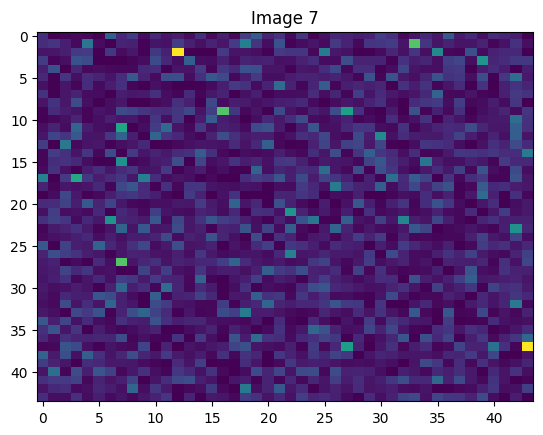

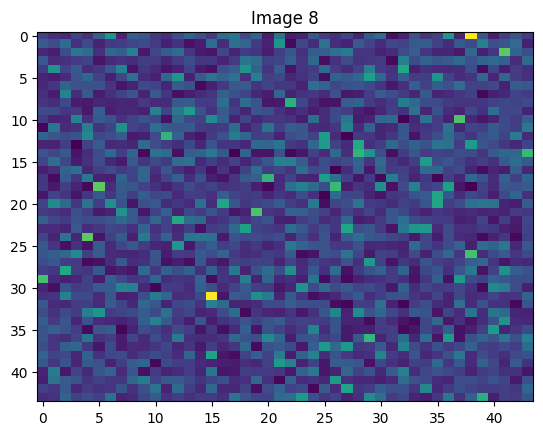

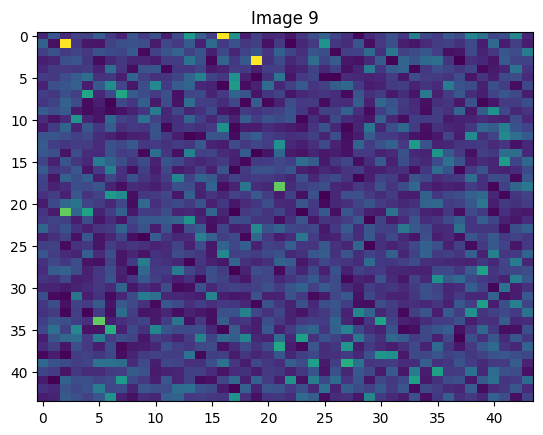

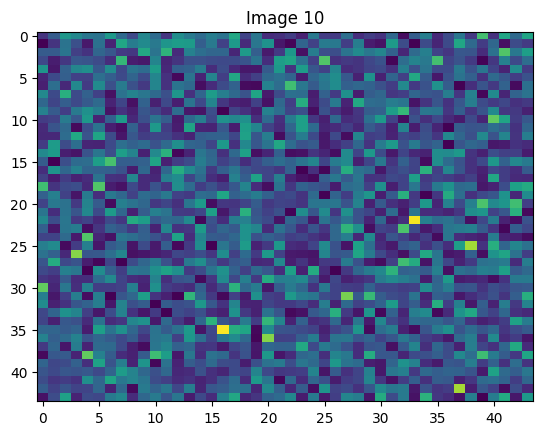

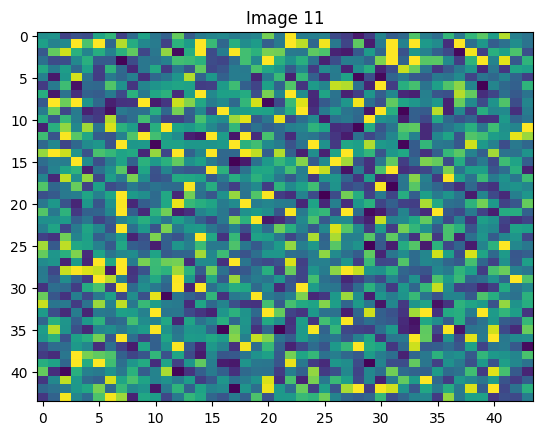

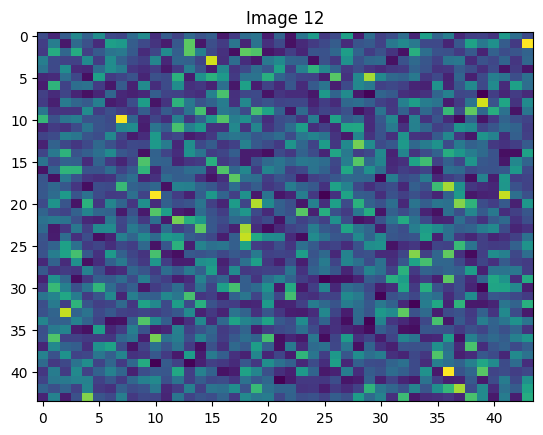

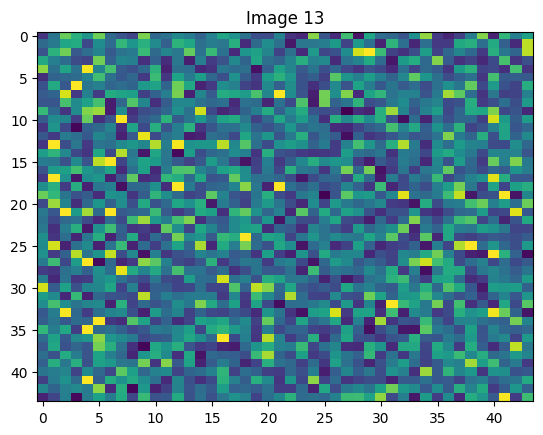

In [34]:
nrows, ncols  = X_test.shape
# Normalize the data to the range [0, 1]

# Convert the normalized features to a 2D image, where each row is an image
image_data1 = (X_test * 255).astype(np.uint8).reshape((nrows, size, size))
#print(image_data)
print(image_data1.shape)
#Display all images
for i in range(nrows):
    plt.imshow(image_data1[i], cmap='viridis', aspect='auto')
    plt.title(f"Image {i + 1}")
    plt.show()

In [35]:
# Train the model
history = densenet_model.fit(image_data1, y_test, epochs=20, batch_size=32, validation_split=0.2)


# Evaluate the model on the test set
loss, accuracy = densenet_model.evaluate(image_data1,y_test,verbose =0)

print(f'Accuracy: {accuracy:.4f}')
# Save the trained model (optional)
densenet_model.save('densenet_modelt.keras')

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 28.4410 - val_accuracy: 1.0000 - val_loss: 28.4625
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 28.3247 - val_accuracy: 1.0000 - val_loss: 28.3543
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 28.2098 - val_accuracy: 1.0000 - val_loss: 28.2479
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 28.0958 - val_accuracy: 1.0000 - val_loss: 28.1464
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 27.9834 - val_accuracy: 1.0000 - val_loss: 28.0528
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 27.8719 - val_accuracy: 1.0000 - val_loss: 27.9592
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 27.7615 - val_accuracy: 1.0000 - val_loss: 27.8654
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 27.6521 - val_accuracy: 1.0000 - 

**TESTING**

In [36]:
densenet_model.save("densenet_modelt.keras")


Saving download (14).png to download (14) (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


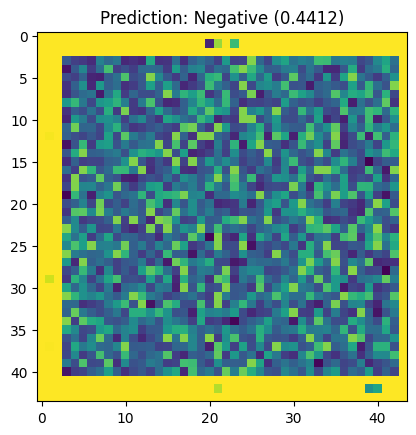

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import cv2

# Upload an image
uploaded = files.upload()

# Load the trained DenseNet model
model = load_model("densenet_modelt.keras")

# Process the uploaded image
for filename in uploaded.keys():
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (size, size))  # Resize to match training dimensions
    img = img / 255.0  # Normalize to match training preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img)[0][0]

    # Determine the output class
    result = "Positive" if prediction >= 0.5 else "Negative"

    # Display the image and result
    plt.imshow(img[0], cmap="viridis")
    plt.title(f"Prediction: {result} ({prediction:.4f})")
    plt.show()


**CNN**

In [22]:
from tensorflow.keras import layers, models
import numpy as np
import sklearn.metrics

# Reshape image_data to include a single channel (grayscale)
image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)

def build_cnn_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Initialize and compile the model
cnn_model = build_cnn_model(image_data.shape[1:])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(image_data, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
y_pred = cnn_model.predict(image_data)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

# Compute evaluation metrics
precision = sklearn.metrics.precision_score(y_train, y_pred_binary)
recall = sklearn.metrics.recall_score(y_train, y_pred_binary)
f1 = sklearn.metrics.f1_score(y_train, y_pred_binary)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_binary)

print(f'CNN Model - Precision: {precision:.4f}')
print(f'CNN Model - Recall: {recall:.4f}')
print(f'CNN Model - F1 Score: {f1:.4f}')
print(f'CNN Model - Accuracy: {accuracy:.4f}')

# Save the trained CNN model
cnn_model.save('cnn_model.keras')


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.3881 - loss: 11.2492 - val_accuracy: 0.6000 - val_loss: 22.6793
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6736 - loss: 14.0618 - val_accuracy: 0.4000 - val_loss: 11.0596
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3368 - loss: 10.1429 - val_accuracy: 0.6000 - val_loss: 2.8140
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6907 - loss: 1.5132 - val_accuracy: 0.6000 - val_loss: 6.2322
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 0.6907 - loss: 3.6384 - val_accuracy: 0.6000 - val_loss: 3.6111
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6974 - loss: 1.7248 - val_accuracy: 0.4000 - val_loss: 1.7605
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3435 - loss: 1.3264 - val_accuracy: 0.4000 - val_loss: 1.0247
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8833 - loss: 0.3091 - val_accuracy: 0.6000 - val_loss: 1.4887
E

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
CNN Model - Precision: 0.8750
CNN Model - Recall: 0.8235
CNN Model - F1 Score: 0.8485
CNN Model - Accuracy: 0.8980


In [23]:
# Train the model
history = cnn_model.fit(image_data1, y_test, epochs=20, batch_size=32, validation_split=0.2)


# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(image_data1,y_test,verbose =0)

print(f'Accuracy: {accuracy:.4f}')
# Save the trained model (optional)
cnn_model.save('cnn_model.keras')

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=uint8)
  • training=True
  • mask=None

**TESTING**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import cv2

# Upload an image
uploaded = files.upload()

# Load the trained CNN model
model = load_model("cnn_model.keras")  # Ensure this model is saved in the correct path

# Process the uploaded image
for filename in uploaded.keys():
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (size, size))  # Resize to match training dimensions
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (for CNN input)

    # Make a prediction
    prediction = model.predict(img)[0][0]

    # Determine the output class
    result = "Positive" if prediction >= 0.5 else "Negative"

    # Display the image and result
    plt.imshow(img[0, :, :, 0], cmap="viridis")
    plt.title(f"Prediction: {result} ({prediction:.4f})")
    plt.show()


**DNN**

In [ ]:
from tensorflow.keras import layers, models

def build_dnn_model(input_shape):
    model = models.Sequential()

    model.add(layers.Flatten(input_shape=input_shape))  # Flatten input features
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Initialize and compile the DNN model
dnn_model = build_dnn_model(image_data.shape[1:])
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the DNN model
history = dnn_model.fit(image_data, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the DNN model
y_pred = dnn_model.predict(image_data)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

# Compute evaluation metrics
precision = sklearn.metrics.precision_score(y_train, y_pred_binary)
recall = sklearn.metrics.recall_score(y_train, y_pred_binary)
f1 = sklearn.metrics.f1_score(y_train, y_pred_binary)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_binary)

print(f'DNN Model - Precision: {precision:.4f}')
print(f'DNN Model - Recall: {recall:.4f}')
print(f'DNN Model - F1 Score: {f1:.4f}')
print(f'DNN Model - Accuracy: {accuracy:.4f}')

# Save the trained DNN model
dnn_model.save('dnn_model.keras')

**TESTING**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import cv2

# Upload an image
uploaded = files.upload()

# Load the trained DNN model
model = load_model("/content/dnn_model.keras")  # Ensure the correct model path

# Set the expected input size based on the training data
IMG_SIZE = 44  # Update this if your model was trained on a different size

# Process the uploaded image
for filename in uploaded.keys():
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to match model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 44, 44, 1)

    # Make a prediction
    prediction = model.predict(img)[0][0]

    # Determine the output class
    result = "Positive" if prediction >= 0.5 else "Negative"

    # Display the image and result
    plt.imshow(img[0, :, :, 0], cmap="viridis")
    plt.title(f"Prediction: {result} ({prediction:.4f})")
    plt.axis("off")
    plt.show()
